<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/SHAP_IMAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.5 MB/s eta 0:00:00


Preparing Model on ImageNet Pretrained Weights:


In [8]:
import json

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

import shap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
model.to(device)
model.eval()
X, y = shap.datasets.imagenet50()
print('number of images:', X.shape)

number of images: (50, 224, 224, 3)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.


Preparing Data

Number of ImageNet classes: 1000


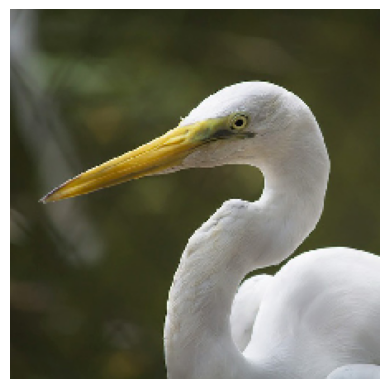

In [15]:
# Getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))

# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

Xtr = transform(torch.Tensor(X))
img = inv_transform(Xtr).cpu().numpy()[1]
plt.imshow(img)
plt.axis('OFF');

Prediction:

In [14]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

# Check that transformations work correctly
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[1:3])
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [132 814]: ['American_egret' 'speedboat']


Explain the prediction with SHAP

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:38, 338.50s/it]              


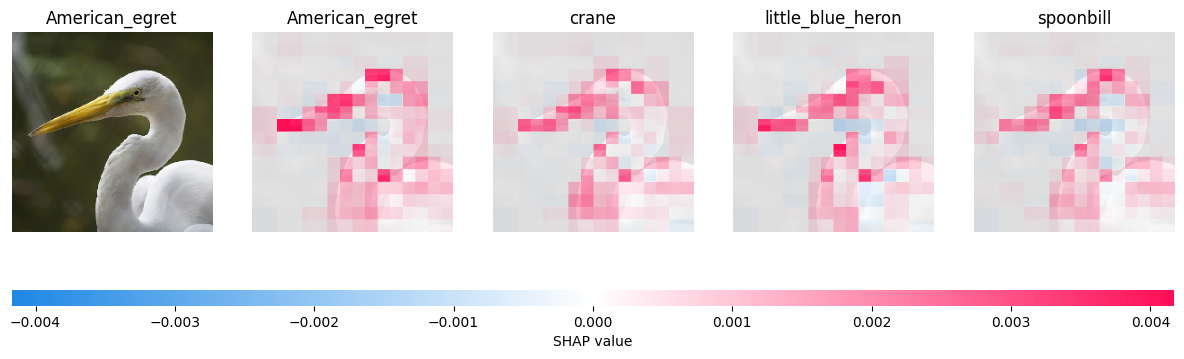

In [16]:
topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[1:2],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[132]],
)